## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob

from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Declaring Data Paths

In [ ]:
base_path = '/content/drive/MyDrive/'

train = '/content/drive/MyDrive/Train' 
test = '/content/drive/MyDrive/Test'
val = '/content/drive/MyDrive/Val'

## Visualisation of Datasets

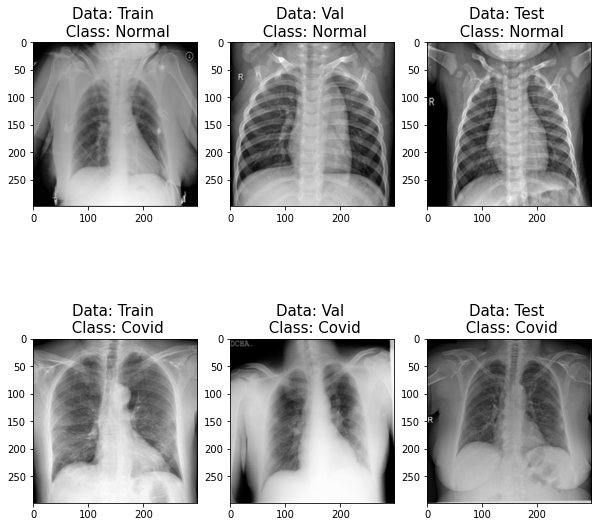

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (10, 10))
ax = ax.ravel()

for i, var in enumerate(['Train', 'Val', 'Test']):
    normal_set = glob.glob(base_path + "/"+ var +"/Normal/*.png")
    covid_set = glob.glob(base_path + "/"+ var + "/COVID/*.png")
    ax[i].imshow(plt.imread(normal_set[0]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Class: Normal'.format(var), fontsize = 15)
    ax[i+3].imshow(plt.imread(covid_set[0]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Class: Covid'.format(var), fontsize = 15)

## Training Data Visualisation

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

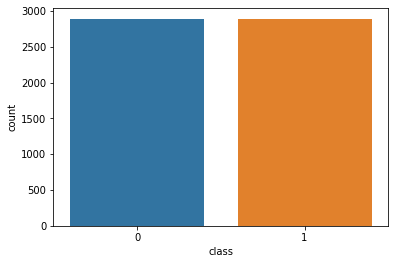

In [ ]:
normal_set = glob.glob(train+"/Normal/*.png")
covid_set = glob.glob(train+"/COVID/*.png")

data = pd.DataFrame(np.concatenate([[0]*len(normal_set),[1]*len(covid_set)]), columns=["class"])
sns.countplot(data['class'],data=data)

## Representing Training DataSet

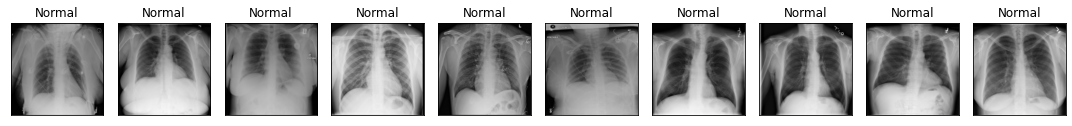

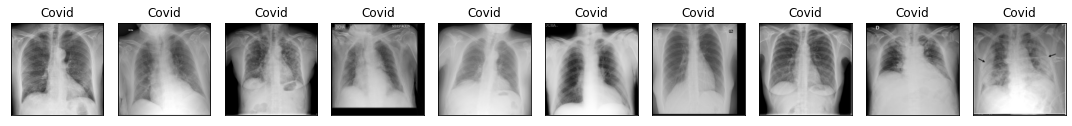

In [ ]:
s = (256, 256)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_set[i])
    img = cv2.resize(img, s)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_set[i])
    img = cv2.resize(img, s)
    ax.imshow(img)
    ax.set_title("Covid")
fig.tight_layout()
plt.show()

## Cany Edge Detection

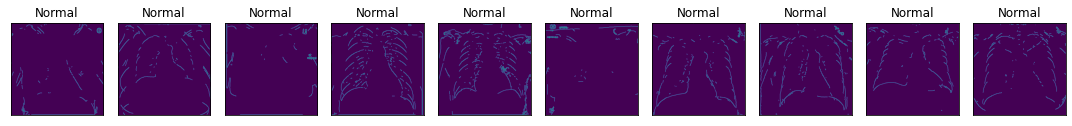

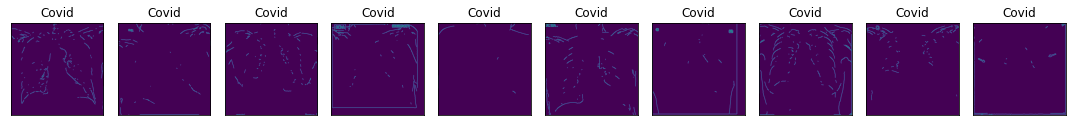

In [ ]:
img_size = (512, 512)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_set[i])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(covid_set[i])
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Covid")
fig.tight_layout()
plt.show()

## Creating Image Data Generators

In [ ]:
# def pre_processing(image):
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.Canny(image, 80, 100)
#     return image

In [ ]:
# gen_train = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2,preprocessing_function=pre_processing)
# gen_val = ImageDataGenerator(rescale = 1./255.,preprocessing_function=pre_processing)
# gen_test = ImageDataGenerator(rescale = 1./255.,preprocessing_function=pre_processing)

# train_gen = gen_train.flow_from_directory(train, batch_size = 20, class_mode = 'categorical', target_size = (220, 220))
# validation_gen = gen_val.flow_from_directory(val, batch_size = 20, class_mode = 'categorical', target_size=(220, 220))
# test_gen = gen_test.flow_from_directory(test, shuffle = False, batch_size=20, class_mode = 'categorical', target_size=(220, 220))

## Defining the Model

In [ ]:
from keras.applications.resnet import ResNet101
from keras.models import Model

# Load the ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(256, activation='relu')(x)

# Add a logistic layer
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create the data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train,
        target_size=(220,220),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val,
        target_size=(220, 220),
        batch_size=20,
        class_mode='categorical')

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train_generator, validation_data = validation_generator, batch_size=256, epochs = 10, callbacks = callback)

# Train the model
# model.fit_generator(
#         train_generator,
#         steps_per_epoch = 5786 // 20,
#         epochs = 10,
#         validation_data = validation_generator,
#         validation_steps = 632 // 20)


171446536/171446536 [==============================] - 1s 0us/step
Found 5786 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
Epoch 1/10
290/290 [==============================] - 1028s 3s/step - loss: 0.6567 - accuracy: 0.6248 - val_loss: 0.5819 - val_accuracy: 0.5125
Epoch 2/10
290/290 [==============================] - 95s 327ms/step - loss: 0.5832 - accuracy: 0.6941 - val_loss: 0.3927 - val_accuracy: 0.8490
Epoch 3/10
290/290 [==============================] - 96s 330ms/step - loss: 0.5777 - accuracy: 0.7058 - val_loss: 0.3037 - val_accuracy: 0.9446
Epoch 4/10
290/290 [==============================] - 95s 326ms/step - loss: 0.5681 - accuracy: 0.7152 - val_loss: 0.3136 - val_accuracy: 0.9474
Epoch 5/10
290/290 [==============================] - 95s 327ms/step - loss: 0.5548 - accuracy: 0.7226 - val_loss: 0.2954 - val_accuracy: 0.9321
Epoch 6/10
290/290 [==============================] - 95s 328ms/step - loss: 0.5502 - accuracy: 0.7274 - val_loss: 0.2794 - va

In [ ]:
from keras.applications.resnet import ResNet101
from keras.models import Model
# Load the ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False,input_shape=(220,220,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.summary()

171446536/171446536 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 42,920,706
Trainable params: 262,530
Non

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 40, epochs = 11, callbacks = callback)

In [ ]:
model.save("RestNet101.h5")
np.save("RestNet101.npy",history.history)